# Segmentación de palabras
#### Objetivo 2


In [13]:
import skimage
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import cv2
from sklearn.model_selection import train_test_split
import time
from sklearn.cluster import DBSCAN
from skimage.transform import rescale
import pandas as pd
import random
from torchvision.models import resnet50, ResNet18_Weights
import torch
from torch import nn
import copy
import splitfolders
from torchvision import  models, transforms, datasets
import torch.optim as optim
from tqdm import tqdm
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from thefuzz import fuzz
import json
from sklearn import metrics
import Levenshtein
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore")
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

colors = ["#e8e8e8",  "#feb2b7","#fc626b", "#a7d3fd", "#0080fa", "#03133f"]  
custom_palette = ListedColormap(sns.color_palette(colors))

### Utils

In [14]:
class_to_character_table = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "A", 11: "B", 12: "C", 13: "D", 14: "E", 15: "F", 16: "G", 17: "H", 18: "I", 19: "J", 20: "K",
    21: "L", 22: "M", 23: "N", 24: "O", 25: "P", 26: "Q", 27: "R", 28: "S", 29: "T", 30: "U", 31: "V", 
    32: "W", 33: "X", 34: "Y", 35: "Z", 36: "a", 37: "b", 38: "c", 39: "d", 40: "e", 41: "f", 42: "g",
    43: "h", 44: "i", 45: "j", 46: "k", 47: "l", 48: "m", 49: "n", 50: "o", 51: "p", 52: "q", 53: "r",
    54: "s", 55: "t", 56: "u", 57: "v", 58: "w", 59: "x", 60: "y", 61: "z"
    }

def rescale(img, shortest_side=1500):
    ## Resize image maintaining the aspect ratio. Shortest side of the
    ## image will be "shortest_side" pxs long.
    (w, h) = img.shape
    dim = (int(shortest_side/w * h), shortest_side) if w < h\
          else (shortest_side, int(shortest_side/h * w))
    img = cv2.resize(img, dim, interpolation=cv2.INTER_NEAREST)
    return img

def black_hat_preproc(img, size=13):
    ## Apply black hat transform
    kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, 
        ksize=(size, size))
    black_hat = cv2.morphologyEx(
        img, 
        cv2.MORPH_BLACKHAT,
        kernel)
    return cv2.threshold(255 - black_hat, 200, 255, cv2.THRESH_BINARY)[1]

def word_mask(img, kernel, iterations=10):
    # Dilate
    mask = cv2.dilate(255-img, kernel, iterations=iterations)
    # Open
    kernel_opening = np.ones((3, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_opening, iterations=3)
    return img*mask, mask

def remove_lines(img):
    kernel_opening = np.ones((1, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_opening, iterations=1)

    kernel_opening = np.ones((5, 1), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_opening, iterations=1)

    kernel_opening = np.ones((3, 3), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_opening, iterations=1)
    return img

def preprocess_image(img, is_digital):
    processed = black_hat_preproc(img)
    if is_digital:
        kernel = np.ones((1, 2), np.uint8)
        iters = 15
    else:
        kernel = np.ones((2, 5), np.uint8)
        iters = 10
    return word_mask(processed, kernel, iters)[1]

### Load data and preprocess

In [15]:
# Read document images
files = os.listdir("data/data_manual/train/digital/")
image_files_digital = ["data/data_manual/train/digital/"+i for i in files]

files = os.listdir("data/data_manual/train/manual/")
image_files_manual = ["data/data_manual/train/manual/" + file for file in files]

original_data = {
    "digital":
        [rescale(cv2.imread(file, cv2.IMREAD_GRAYSCALE)) for file in image_files_digital],
    "manual":
        [rescale(cv2.imread(file, cv2.IMREAD_GRAYSCALE)) for file in image_files_manual]
}

In [16]:
binarized_data = {
    "digital":
        [cv2.threshold(i, 170, 255, cv2.THRESH_BINARY)[1] for i in original_data["digital"]],
    "manual":
        [cv2.threshold(i, 170, 255, cv2.THRESH_BINARY)[1] for i in original_data["manual"]]
}

In [ ]:

black_hat_data = {
    "digital":
        [black_hat_preproc(i) for i in original_data["digital"]],
    "manual":
        [black_hat_preproc(i) for i in original_data["manual"]]
}


In [ ]:
kernel_digital = np.ones((1, 2), np.uint8)
iters_digital = 15
kernel_manual = np.ones((2, 5), np.uint8)
iters_manual = 10

word_mask_data = {
    "digital":
        [word_mask(i, kernel_digital, iters_digital)[1] for i in black_hat_data["digital"]],
    "manual":
        [word_mask(i, kernel_manual, iters_manual)[1] for i in black_hat_data["manual"]]
}

In [ ]:
# Imagen original, binarizada, black hat + binarizacion, máscara de palabras con dilatación y opening
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0, 0].imshow(original_data["manual"][23], cmap="gray")
ax[0, 1].imshow(binarized_data["manual"][23], cmap="gray")
ax[0, 2].imshow(black_hat_data["manual"][23], cmap="gray")
ax[0, 3].imshow(word_mask_data["manual"][23], cmap="gray")
ax[1, 0].imshow(original_data["digital"][50], cmap="gray")
ax[1, 1].imshow(binarized_data["digital"][50], cmap="gray")
ax[1, 2].imshow(black_hat_data["digital"][50], cmap="gray")
ax[1, 3].imshow(word_mask_data["digital"][50], cmap="gray")
plt.show()  

### Segmentation

In [24]:
def get_bboxes(dilated_img, origin_img, plot=False):
    # Get contours using the word mask images
    contours, _ = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Filter countours by size and ammount of black pixels
    coord = []
    for contour in contours:  
        [x,y,w,h] = cv2.boundingRect(contour)
        t = origin_img[y:y+h,x:x+w]
        if h>500 and w>500:   
            continue
        if np.sum((255-t)/255) < t.shape[0]*t.shape[1]*0.02:
            continue
        if w/h < 1/5:
            continue
        if w/h > 30:
            continue
        coord.append((x,y,w,h)) 

    if plot:
        fig, ax = plt.subplots(1, 1, figsize= (16, 6))
        ax.imshow(origin_img, cmap="gray")
        for cor in coord:
            [x,y,w,h] = cor
            ax.add_patch(plt.Rectangle((x, y), w, h, alpha=1, fill=None, edgecolor="red"))
        plt.show()
    return coord

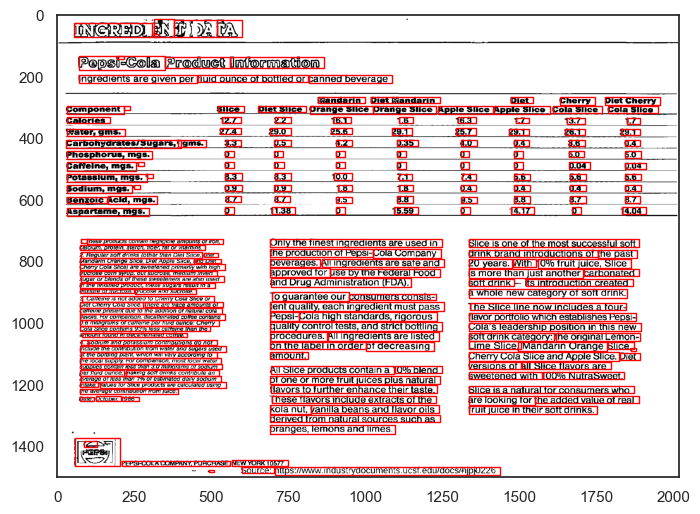

In [25]:
dataset = "digital"
#_img = 95
n_img = random.randint(0, len(black_hat_data[dataset]))
origin_image = black_hat_data[dataset][n_img]
dilated = word_mask_data[dataset][n_img]
    
cajas = get_bboxes(dilated, origin_image, plot=True);

### Classifier

In [10]:
# Create train/test/val splits
#splitfolders.ratio('data/Numbers and characters/Chars74k/Dataset final', output="data/character_classification", seed=0, ratio=(.8, 0.1,0.1))

input_size = (224,224)
crop_size = input_size
data_transforms = {
    'train': transforms.Compose([
        #transforms.Grayscale(),
        transforms.Resize(input_size),
        transforms.ToTensor()
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Grayscale(),
        transforms.Resize(input_size),
        transforms.ToTensor()
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
kwargs = {"batch_size": 128, "num_workers": 8, "pin_memory": True}

train = datasets.ImageFolder("data/character_classification/train", data_transforms["train"])
test = datasets.ImageFolder("data/character_classification/test", data_transforms["test"])
val = datasets.ImageFolder("data/character_classification/val", data_transforms["test"])

dataloaders_dict = {
    "train": torch.utils.data.DataLoader(train, shuffle=True, **kwargs), 
    "test": torch.utils.data.DataLoader(test, shuffle=False, **kwargs),
    "val": torch.utils.data.DataLoader(val, shuffle=False, **kwargs)
    }

In [12]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, only_validation=False):
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        splits = ["val"] if only_validation else ["train", "val"]
        for phase in splits:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss.cpu().detach().numpy())

                    _, preds = torch.max(outputs, 1)
                    if phase == "val":
                        all_preds += preds.tolist()
                        all_labels += labels.tolist()
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.detach().cpu().numpy().item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "character_class_model.state")
            
            acc_history[phase].append(epoch_acc.detach().cpu().numpy())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    if not only_validation:
        # load best model weights
        model.load_state_dict(best_model_wts)
    return model, acc_history, losses, all_preds, all_labels

#### Load models

In [13]:
# Load Resnet-18 model pretrained on IMAGENET
model_char_class = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_char_class.fc = nn.Linear(512, 62, bias=True)

# Send the model to GPU
model_char_class = model_char_class.to(device)

# Train and evaluate
if False:
    # Setup the loss fxn
    criterion = nn.CrossEntropyLoss()

    # Number of epochs to train for 
    num_epochs = 3

    optimizer_ft = optim.Adam(model_char_class.parameters(), lr=0.001)
    model_char_class, hist, losses, _, _ = train_model(model_char_class, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
    torch.save(model.state_dict(), "character_class_model.state")
else:
    # Load model from checkpoint
    model_char_class.load_state_dict(torch.load("character_class_model.state"))

Using cache found in C:\Users\jordi/.cache\torch\hub\pytorch_vision_v0.10.0


In [14]:
# Load RandomForest data for document classification
with open("data_vpc.sav", "rb") as file:
    model_data = pickle.load(file)

#### Character classification model: Evaluation and confusion matrix

In [15]:
criterion = nn.CrossEntropyLoss()
num_epochs = 3
optimizer_ft = optim.Adam(model_char_class.parameters(), lr=0.001)
_, _, _, preds, labels = train_model(model_char_class, dataloaders_dict, criterion, optimizer_ft, num_epochs=1, only_validation=True);

Epoch 0/0
----------


100%|██████████| 52/52 [02:24<00:00,  2.78s/it]

val Loss: 0.7953 Acc: 0.8456
Training complete in 2m 25s
Best val Acc: 0.845644


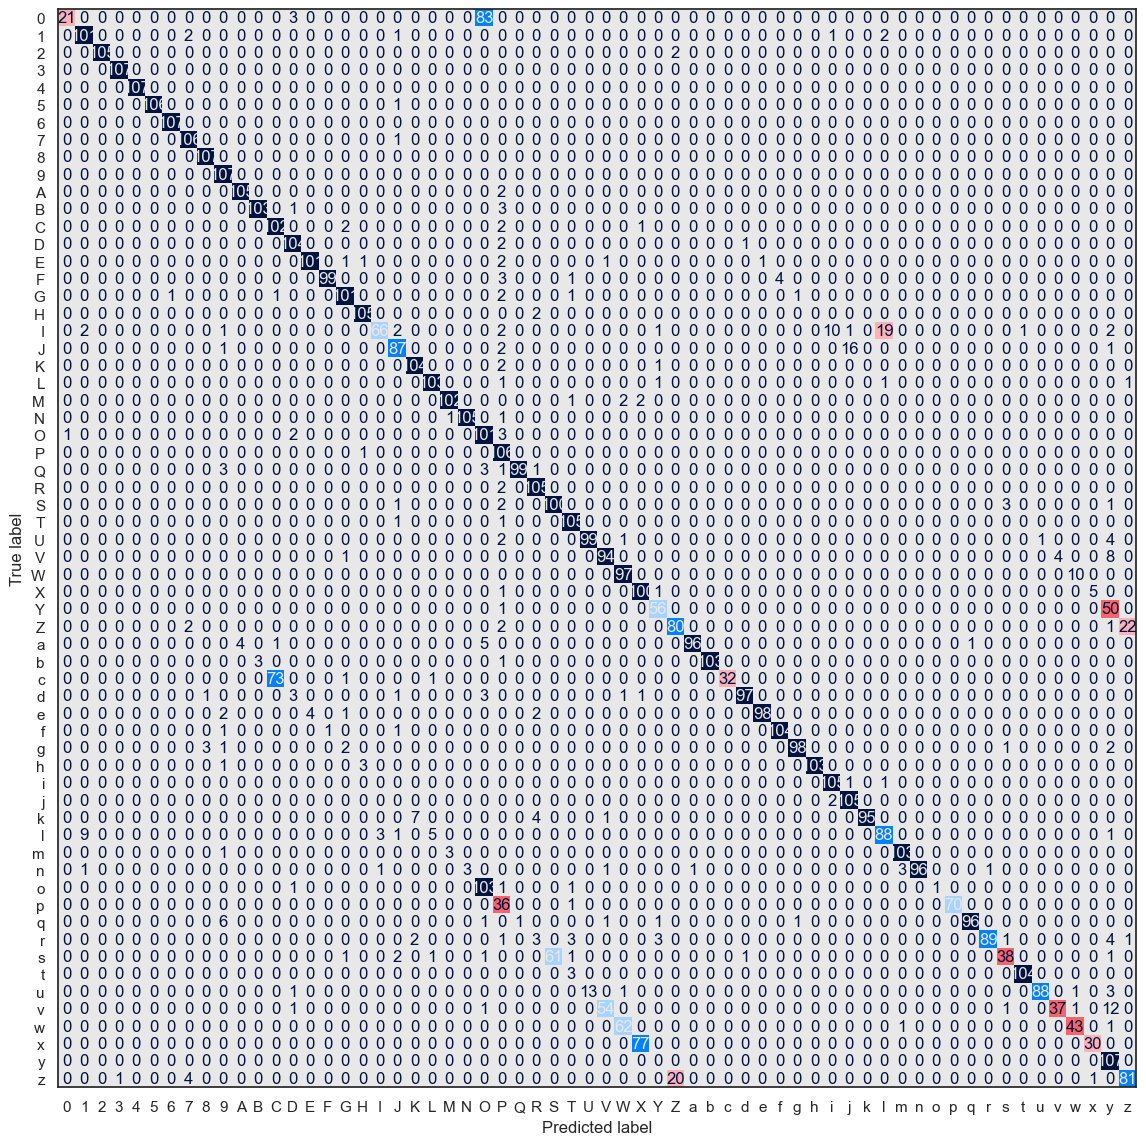

In [16]:
sns.set(style="white")
colors = ["#e8e8e8",  "#feb2b7","#fc626b", "#a7d3fd", "#0080fa", "#03133f"]  
custom_palette = ListedColormap(sns.color_palette(colors))

matriu_confusio = metrics.confusion_matrix(labels, preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=matriu_confusio,
                                                display_labels=[i for i in range(0, 62)])
fig, ax = plt.subplots(figsize=(14, 14))
cm_display.plot(ax=ax, cmap=custom_palette)
cm_display.im_.colorbar.remove()
ax.set_xticklabels([class_to_character_table[i] for i in range(0, 62)])
ax.set_yticklabels([class_to_character_table[i] for i in range(0, 62)])
plt.show()

### OCR

In [17]:
def classify_doc(img):
    img = cv2.resize(img, model_data["image_sizes"], interpolation = cv2.INTER_CUBIC)
    PCA = model_data["pca_transform"]
    img = PCA.transform(img.flatten().reshape(1, -1))[:, :model_data["pca_dimensions"]]
    pred = model_data["model"].predict(img)
    # 0 -> Digital document
    # 1 -> Manual document
    return pred == 0

def discard_chars(img):
    if type(img) == type(None):
        return True
    h, w = img.shape
    if sum(sum(255 - img[int(h/2 - 1):int(h/2 + 1) ,:])) == 0:
        return True


def ocr_box(origin_image, plot=False):
    is_digital = classify_doc(origin_image)
    dilated_image = preprocess_image(origin_image, is_digital)
    black_hat_image = black_hat_preproc(origin_image, size=21)
    boxes = get_bboxes(dilated_image, origin_image, plot=plot)
    ocr = []
    if is_digital:
        for box in boxes:
            [x,y,w,h] = box
            # Segmented word
            word_image = black_hat_image[max(0, y-5):y+h+5,max(0, x-5):x+w+5]

            # Split the word image by looking at the columns without black pixels
            h = np.sum(255-word_image, axis=0)
            if min(h) != 0:
                h = h - min(h)
            cuts = [0]
            for i, val in enumerate(h):
                if h[i-1] != 0 and val == 0:
                    cuts.append(i)

            string = ""
            # Iterate over each "character" of the word image
            for start, end in zip(cuts[:-1], cuts[1:]):
                # Segmented character
                char = word_image[:, start:end]

                # Preprocess character: Add padding to square, resize to (224, 224), add dimensions to meet model requirements
                h, w = char.shape
                if h < w:
                    char = cv2.copyMakeBorder(char, int((w-h)/2), int((w-h)/2), 0, 0, borderType=cv2.BORDER_CONSTANT, value=255)                    
                else:
                    char = cv2.copyMakeBorder(char, 0, 0, int((h-w)/2), int((h-w)/2), borderType=cv2.BORDER_CONSTANT, value=255)
                if discard_chars(char):
                    continue
                char = cv2.resize(char, (224, 224), interpolation = cv2.INTER_CUBIC)
                char = cv2.cvtColor(char, cv2.COLOR_GRAY2RGB)
                char = np.moveaxis(char, 2, 0)
                char = torch.unsqueeze(torch.from_numpy(char), dim=0)
                
                logits = model_char_class(char.float() / 255)
                preds = nn.Softmax(dim=1)(logits)
                preds = class_to_character_table[np.argmax(preds.detach().numpy())].lower()

                if False:
                    plt.imshow(char[0, :, :, :].float().permute(1, 2, 0) / 255)
                    plt.show()
                    print(preds)
                string += preds
            if False:
                plt.imshow(word_image, cmap="gray")
                plt.show()
                print(string)
            ocr.append({"boundingBox": box, "text": string})
    else:
        for box in boxes:
            [x,y,w,h] = box
            word_image = black_hat_image[y-5:y+h+5,x-5:x+w+5]

            windows_width = 0.8
            stride = 5
            current_pos = 0
            string = ""
            while(current_pos+h*windows_width < w):
                char = word_image[:, current_pos:int(h*windows_width)]
                h, w = char.shape
                if h < w:
                    char = cv2.copyMakeBorder(char, int((w-h)/2), int((w-h)/2), 0, 0, borderType=cv2.BORDER_CONSTANT, value=255)                    
                else:
                    char = cv2.copyMakeBorder(char, 0, 0, int((h-w)/2), int((h-w)/2), borderType=cv2.BORDER_CONSTANT, value=255)
                if discard_chars(char):
                    continue
                char = cv2.resize(char, (224, 224), interpolation = cv2.INTER_NEAREST)
                char = cv2.cvtColor(char, cv2.COLOR_GRAY2RGB)
                char = np.moveaxis(char, 2, 0)
                char = torch.unsqueeze(torch.from_numpy(char), dim=0)
                
                logits = model_char_class(char.float() / 255)
                preds = nn.Softmax(dim=1)(logits)
                preds = class_to_character_table[np.argmax(preds.detach().numpy())].lower()
                current_pos += stride
                string += preds

            best_score = -1
            with open("most_common_words.txt", "r") as file:
                for line in file:
                    word = line[:-1]
                    score = fuzz.ratio(string, word)
                    if score > best_score:
                        best_score = score
                        final_string = word
    
            if False:
                plt.imshow(word_image, cmap="gray")
                plt.show()
                print(f"Carácteres extraidos: {string} \nPalabra asociada: {final_string}")
            ocr.append({"boundingBox": box, "text": final_string})

    return ocr


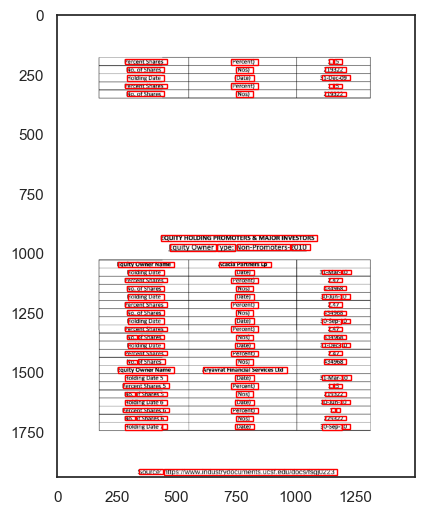

[{'boundingBox': (341, 1908, 103, 20), 'text': 'souyce'},
 {'boundingBox': (449, 1907, 727, 27),
  'text': 'https1mjmdwstyydocwmemtswcsfedw1docs1fsgj0223'},
 {'boundingBox': (1194, 1718, 35, 19), 'text': '10'},
 {'boundingBox': (1112, 1718, 81, 23), 'text': '30isepx'},
 {'boundingBox': (746, 1718, 80, 22), 'text': 'ldgtej'},
 {'boundingBox': (438, 1718, 20, 19), 'text': '7'},
 {'boundingBox': (285, 1718, 152, 23), 'text': 'holdimgdate'},
 {'boundingBox': (1122, 1685, 90, 18), 'text': '229322'},
 {'boundingBox': (284, 1685, 43, 18), 'text': 'no'},
 {'boundingBox': (328, 1684, 133, 19), 'text': 'ofshares6'},
 {'boundingBox': (751, 1683, 70, 24), 'text': 'lnosj'},
 {'boundingBox': (1171, 1651, 17, 18), 'text': '3'},
 {'boundingBox': (1149, 1651, 17, 17), 'text': '1'},
 {'boundingBox': (730, 1650, 113, 23), 'text': 'fpetcemtl'},
 {'boundingBox': (275, 1650, 195, 19), 'text': 'percemtshare6'},
 {'boundingBox': (1192, 1616, 35, 19), 'text': '10'},
 {'boundingBox': (1113, 1616, 78, 19), 'text

In [18]:
dataset = "digital"
n_img = 65 #56, 20
#n_img = random.randint(0, len(black_hat_data[dataset]))
origin_image = black_hat_data[dataset][n_img]
dilated = word_mask_data[dataset][n_img]

ocr_box(origin_image, plot=True)

In [19]:
dataset = "manual"
n_img = 31
#n_img = random.randint(0, len(black_hat_data[dataset]))
origin_image = black_hat_data[dataset][n_img]
dilated = word_mask_data[dataset][n_img]

ocr_box(origin_image)

[{'boundingBox': (331, 1381, 82, 60), 'text': 'all'},
 {'boundingBox': (914, 1364, 182, 97), 'text': 'pay'},
 {'boundingBox': (687, 1351, 191, 88), 'text': 'word'},
 {'boundingBox': (429, 1344, 220, 95), 'text': 'him'},
 {'boundingBox': (69, 1328, 237, 114), 'text': 'will'},
 {'boundingBox': (313, 1202, 510, 111), 'text': 'much'},
 {'boundingBox': (1475, 1191, 355, 131), 'text': 'mother'},
 {'boundingBox': (1839, 1189, 402, 93), 'text': 'common'},
 {'boundingBox': (0, 1189, 277, 172), 'text': 'the'},
 {'boundingBox': (865, 1174, 233, 164), 'text': 'off'},
 {'boundingBox': (1161, 1171, 268, 152), 'text': 'think'},
 {'boundingBox': (306, 1086, 133, 105), 'text': 'way'},
 {'boundingBox': (73, 1058, 198, 89), 'text': 'check'},
 {'boundingBox': (1841, 1055, 308, 92), 'text': 'word'},
 {'boundingBox': (830, 1049, 226, 88), 'text': 'major'},
 {'boundingBox': (1720, 1043, 118, 90), 'text': 'all'},
 {'boundingBox': (1555, 1040, 132, 99), 'text': 'hot'},
 {'boundingBox': (1096, 1038, 432, 128), 

In [20]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [21]:
def segmentation_ocr_stats(n_img, plot=False):
    current_file = image_files_digital[n_img].split("/")[-1].split(".")[0]

    im = cv2.imread("data/DocVQA/val/documents/"+current_file+".png", cv2.IMREAD_GRAYSCALE)
    H, W = im.shape

    with open("data/DocVQA/val/ocr_results/"+current_file+".json") as file:
        data = json.load(file)

    gt_ocr = []
    for line in [line["words"] for line in data["recognitionResults"][0]["lines"]]:
        for word in line:
            gt_ocr.append(word)

    for word in gt_ocr:
        bbox = word["boundingBox"]
        for i, coord in enumerate(bbox):
            if i % 2 == 0:
                bbox[i] = bbox[i] / W
            else:
                bbox[i] = bbox[i] / H

    im_rescaled = rescale(im)
    pred_ocr = ocr_box(im_rescaled, plot=plot)
    H, W = im_rescaled.shape

    for word in pred_ocr:
        [x,y,w,h] = word["boundingBox"]
        new_bbox = [x / W, y / H]
        new_bbox.append((x + w) / W)
        new_bbox.append(y / H)
        new_bbox.append((x + w) / W)
        new_bbox.append((y + h) / H)
        new_bbox.append(x / W)
        new_bbox.append((y + h) / H)
        word["boundingBox"] = new_bbox


    iou_list = []
    levens_list = []
    for word_gt in gt_ocr:
        x1, y1 = word_gt["boundingBox"][:2]
        best_distance = 10
        closest = None
        for word in pred_ocr:
            x2, y2 = word["boundingBox"][:2]
            distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            if distance < best_distance and distance < 0.03:
                closest = word
        if closest != None:
            iou = bb_intersection_over_union(word["boundingBox"], word_gt["boundingBox"])
            if plot:
                gt_rectangle = np.array(word_gt["boundingBox"])
                gt_rectangle[::2] *= W
                gt_rectangle[1::2] *= H
                gt_points = [(gt_rectangle[0], gt_rectangle[1]), (gt_rectangle[2], gt_rectangle[3]), (gt_rectangle[4], gt_rectangle[5]), (gt_rectangle[6], gt_rectangle[7])]
                pred_rectangle = np.array(closest["boundingBox"])
                pred_rectangle[::2] *= W
                pred_rectangle[1::2] *= H
                pred_points = [(pred_rectangle[0], pred_rectangle[1]), (pred_rectangle[2], pred_rectangle[3]), (pred_rectangle[4], pred_rectangle[5]), (pred_rectangle[6], pred_rectangle[7])]
                fig, ax = plt.subplots(1, 1, figsize= (16, 6))
                ax.imshow(im_rescaled, cmap="gray")
                ax.add_patch(plt.Polygon(gt_points, alpha=1, fill=None, edgecolor="green"))
                ax.add_patch(plt.Polygon(pred_points, alpha=1, fill=None, edgecolor="red"))
                plt.show()
                
        iou_list.append(iou if closest != None else "Not found")

        word_similarity = Levenshtein.distance(word["text"], word_gt["text"])
        levens_list.append(word_similarity if closest != None else "Not found")
    return iou_list, levens_list

In [22]:
iou_list, levens_list = segmentation_ocr_stats(1, plot=False)

In [24]:
all_ious = []
iou_means_all = [] # media de todos los IOU (incluido los no encontrados)
iou_means = []

all_leven = []
leven_means_all = []
leven_means = []

for i in tqdm(range(len(image_files_digital))):
    iou_list, levens_list = segmentation_ocr_stats(i, plot=False)
    all_ious += iou_list
    iou_means_all.append(np.mean([i if i != "Not found" else 0 for i in iou_list]))
    iou_means.append(np.mean([i for i in iou_list if i != "Not found"]))
    all_leven += levens_list
    leven_means_all.append(np.mean([i if i != "Not found" else 0 for i in levens_list]))
    leven_means.append(np.mean([i for i in levens_list if i != "Not found"]))

100%|██████████| 200/200 [38:14<00:00, 11.47s/it] 


In [26]:
np.mean([i for i in all_ious if i != "Not found"]), np.mean([i if i != "Not found" else 0 for i in all_ious])

(0.28214802472772516, 0.1358752992774592)

In [27]:
np.mean([i for i in levens_list if i != "Not found"]), np.mean([i if i != "Not found" else 0 for i in levens_list])

(6.030075187969925, 1.7587719298245614)

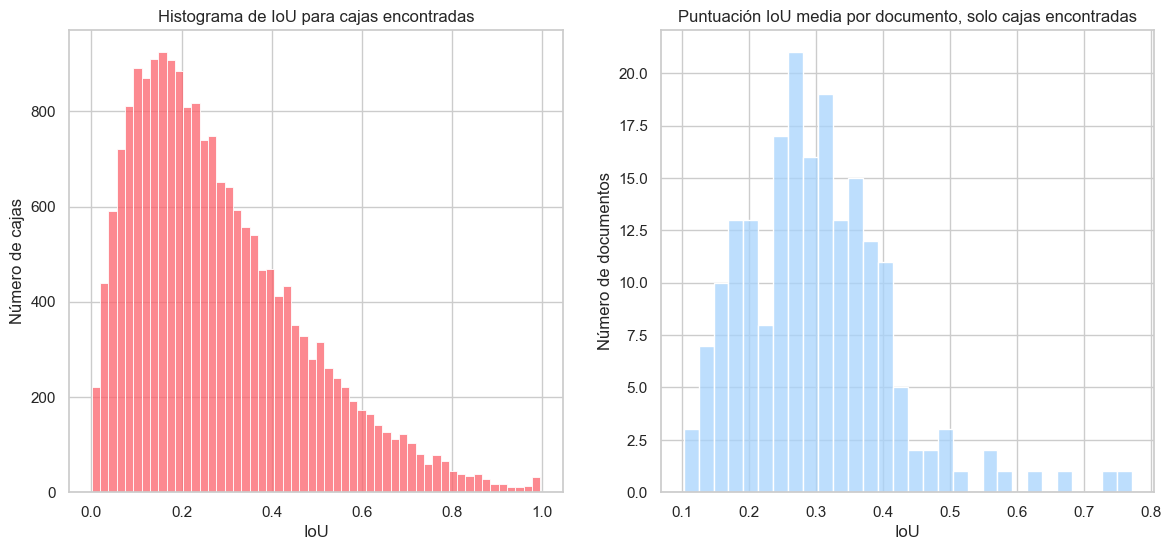

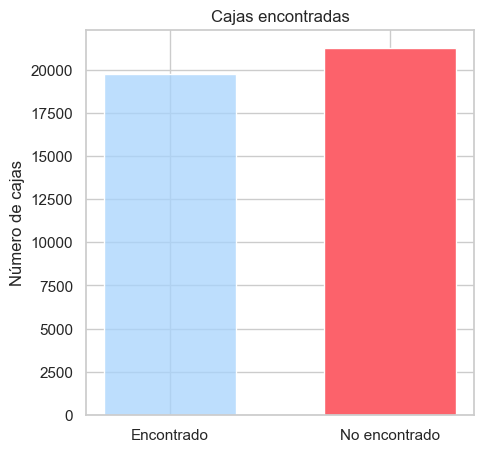

In [67]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
s1=sns.histplot([i for i in all_ious if i != "Not found"], color="#fc626b", ax=axs[0])
s2=sns.histplot([i for i in iou_means], color="#a7d3fd", ax=axs[1], bins=30)
axs[0].set_title("Histograma de IoU para cajas encontradas")
axs[0].set_xlabel("IoU"); axs[0].set_ylabel("Número de cajas")
axs[1].set_title("Puntuación IoU media por documento, solo cajas encontradas")
axs[1].set_xlabel("IoU"); axs[1].set_ylabel("Número de documentos")
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
s2=sns.histplot(["Found" if i != "Not found" else i for i in all_ious], color="#a7d3fd", ax=ax, binwidth=0.5, shrink=0.6)
ax.patches[1].set_facecolor("#fc626b")
ax.set_xticklabels(["Encontrado", "No encontrado"])
ax.set_ylabel("Número de cajas")
ax.set_title("Cajas encontradas")
plt.show()

Text(0, 0.5, 'Número de documentos')

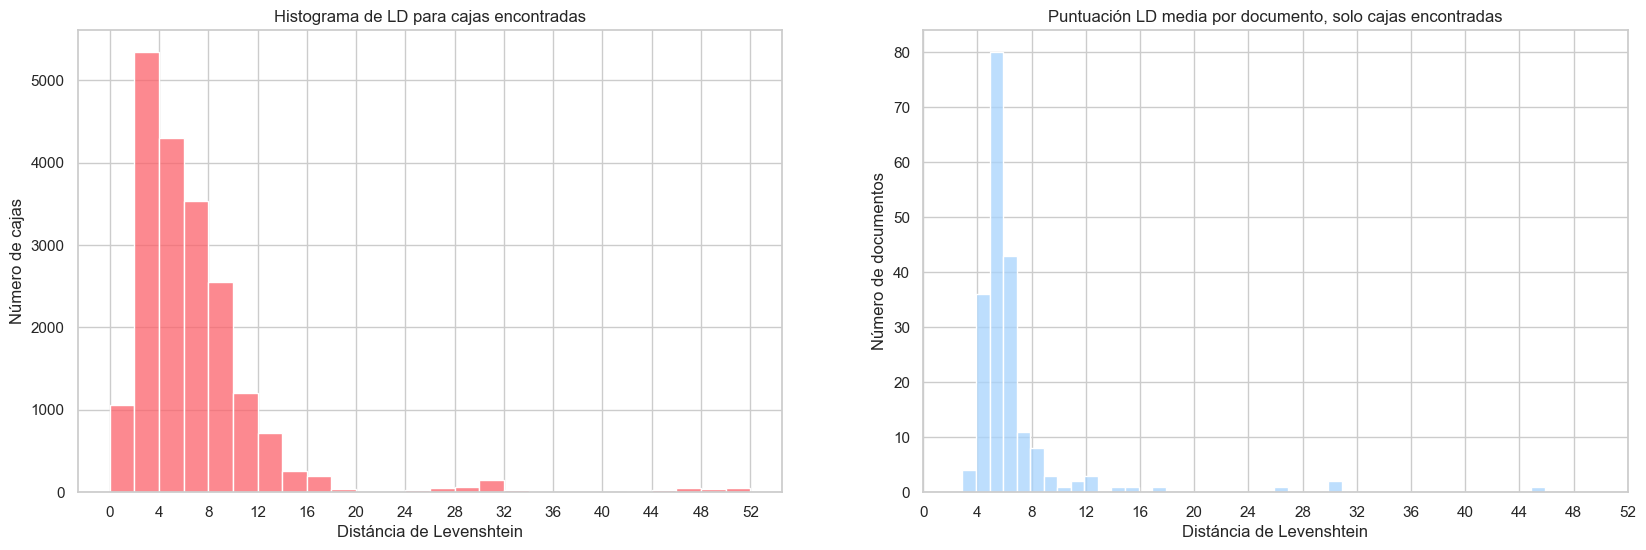

In [92]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
s2=sns.histplot([i for i in all_leven if i != "Not found"], color="#fc626b", ax=axs[0], shrink=1, binwidth=2)
axs[0].set_xticks([i for i in range(0, 55, 4)])
s2=sns.histplot([i for i in leven_means], color="#a7d3fd", ax=axs[1], binwidth=1)
axs[1].set_xticks([i for i in range(0, 55, 4)])

axs[0].set_title("Histograma de LD para cajas encontradas")
axs[1].set_title("Puntuación LD media por documento, solo cajas encontradas");
axs[0].set_xlabel("Distáncia de Levenshtein"); axs[0].set_ylabel("Número de cajas")
axs[1].set_xlabel("Distáncia de Levenshtein"); axs[1].set_ylabel("Número de documentos")

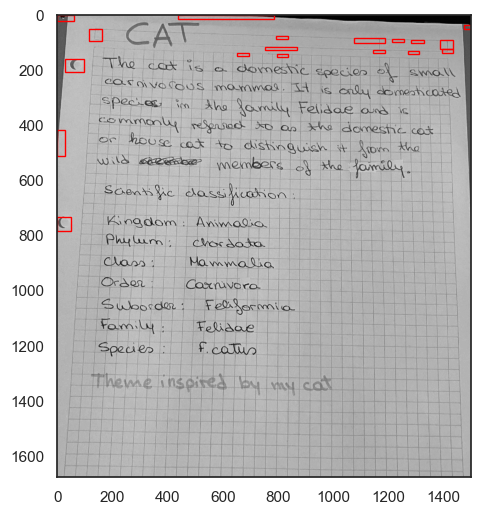

[{'boundingBox': (0, 732, 50, 52), 'text': 'the'}, {'boundingBox': (0, 419, 26, 92), 'text': 'the'}, {'boundingBox': (27, 160, 71, 48), 'text': 'once'}, {'boundingBox': (796, 143, 41, 11), 'text': 'the'}, {'boundingBox': (653, 139, 42, 11), 'text': 'the'}, {'boundingBox': (1273, 130, 41, 11), 'text': 'the'}, {'boundingBox': (1147, 126, 41, 11), 'text': 'the'}, {'boundingBox': (1395, 125, 41, 13), 'text': 'the'}, {'boundingBox': (754, 115, 117, 13), 'text': 'the'}, {'boundingBox': (1390, 92, 45, 31), 'text': 'joy'}, {'boundingBox': (1285, 91, 46, 11), 'text': 'the'}, {'boundingBox': (1215, 89, 43, 11), 'text': 'the'}, {'boundingBox': (1077, 85, 112, 16), 'text': 'the'}, {'boundingBox': (793, 76, 43, 11), 'text': 'the'}, {'boundingBox': (116, 51, 44, 43), 'text': 'joy'}, {'boundingBox': (1475, 35, 25, 17), 'text': 'the'}, {'boundingBox': (437, 0, 348, 16), 'text': 'the'}, {'boundingBox': (0, 0, 59, 22), 'text': 'the'}]


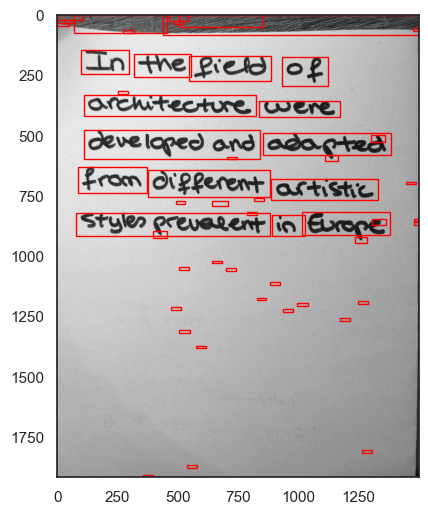

[{'boundingBox': (355, 1909, 42, 8), 'text': 'in'}, {'boundingBox': (539, 1868, 42, 12), 'text': 'the'}, {'boundingBox': (1265, 1804, 42, 12), 'text': 'the'}, {'boundingBox': (577, 1373, 41, 11), 'text': 'the'}, {'boundingBox': (506, 1307, 42, 11), 'text': 'the'}, {'boundingBox': (1173, 1257, 42, 12), 'text': 'the'}, {'boundingBox': (935, 1222, 42, 11), 'text': 'the'}, {'boundingBox': (470, 1213, 41, 11), 'text': 'the'}, {'boundingBox': (996, 1196, 42, 13), 'text': 'the'}, {'boundingBox': (1247, 1186, 42, 12), 'text': 'the'}, {'boundingBox': (826, 1173, 41, 11), 'text': 'the'}, {'boundingBox': (881, 1108, 42, 14), 'text': 'the'}, {'boundingBox': (699, 1052, 41, 11), 'text': 'the'}, {'boundingBox': (504, 1046, 41, 11), 'text': 'the'}, {'boundingBox': (640, 1020, 41, 11), 'text': 'the'}, {'boundingBox': (1233, 922, 52, 24), 'text': 'by'}, {'boundingBox': (396, 895, 59, 30), 'text': 'art'}, {'boundingBox': (1479, 861, 21, 11), 'text': 'the'}, {'boundingBox': (1306, 848, 56, 25), 'text': '

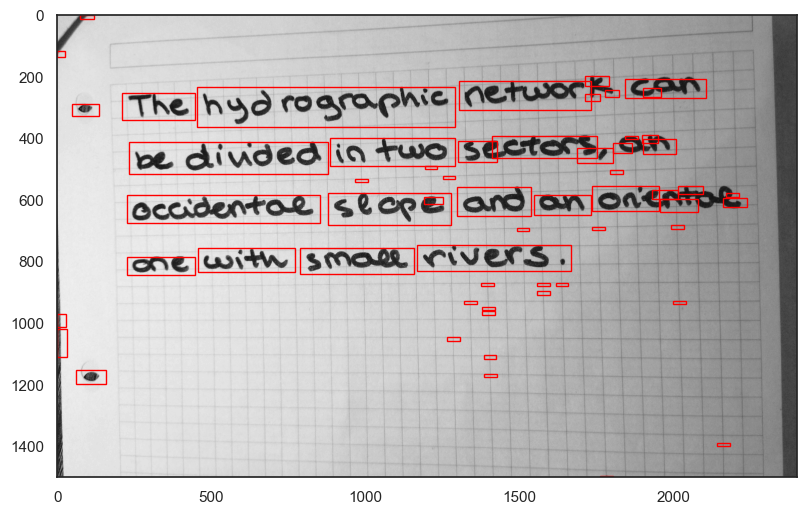

[{'boundingBox': (1762, 1496, 42, 4), 'text': 'the'}, {'boundingBox': (2142, 1390, 41, 11), 'text': 'the'}, {'boundingBox': (1386, 1166, 41, 11), 'text': 'the'}, {'boundingBox': (60, 1152, 97, 46), 'text': 'way'}, {'boundingBox': (1384, 1103, 41, 15), 'text': 'the'}, {'boundingBox': (1265, 1046, 41, 11), 'text': 'the'}, {'boundingBox': (0, 1018, 31, 94), 'text': 'the'}, {'boundingBox': (0, 971, 27, 41), 'text': 'the'}, {'boundingBox': (1380, 961, 41, 14), 'text': 'the'}, {'boundingBox': (1380, 947, 41, 11), 'text': 'the'}, {'boundingBox': (2000, 929, 41, 11), 'text': 'the'}, {'boundingBox': (1320, 929, 41, 11), 'text': 'the'}, {'boundingBox': (1558, 897, 41, 11), 'text': 'the'}, {'boundingBox': (1377, 870, 41, 11), 'text': 'the'}, {'boundingBox': (1618, 869, 41, 11), 'text': 'the'}, {'boundingBox': (1557, 869, 41, 11), 'text': 'the'}, {'boundingBox': (225, 787, 223, 57), 'text': 'act'}, {'boundingBox': (456, 758, 314, 78), 'text': 'much'}, {'boundingBox': (789, 757, 370, 85), 'text': '

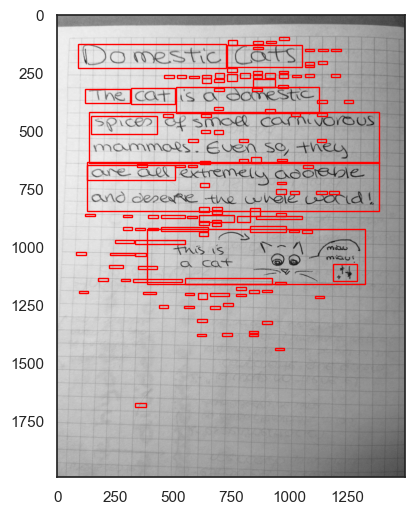

[{'boundingBox': (336, 1672, 45, 20), 'text': 'joy'}, {'boundingBox': (937, 1435, 41, 11), 'text': 'the'}, {'boundingBox': (600, 1375, 41, 11), 'text': 'the'}, {'boundingBox': (824, 1374, 41, 11), 'text': 'the'}, {'boundingBox': (711, 1372, 41, 11), 'text': 'the'}, {'boundingBox': (824, 1362, 41, 11), 'text': 'the'}, {'boundingBox': (881, 1319, 42, 12), 'text': 'the'}, {'boundingBox': (602, 1311, 41, 11), 'text': 'the'}, {'boundingBox': (658, 1256, 42, 11), 'text': 'the'}, {'boundingBox': (547, 1253, 41, 11), 'text': 'the'}, {'boundingBox': (437, 1251, 41, 11), 'text': 'the'}, {'boundingBox': (714, 1243, 41, 11), 'text': 'the'}, {'boundingBox': (1110, 1211, 41, 11), 'text': 'the'}, {'boundingBox': (770, 1203, 41, 11), 'text': 'the'}, {'boundingBox': (659, 1200, 82, 12), 'text': 'the'}, {'boundingBox': (604, 1199, 41, 28), 'text': 'the'}, {'boundingBox': (549, 1198, 41, 11), 'text': 'the'}, {'boundingBox': (371, 1194, 53, 11), 'text': 'the'}, {'boundingBox': (91, 1189, 41, 11), 'text': 

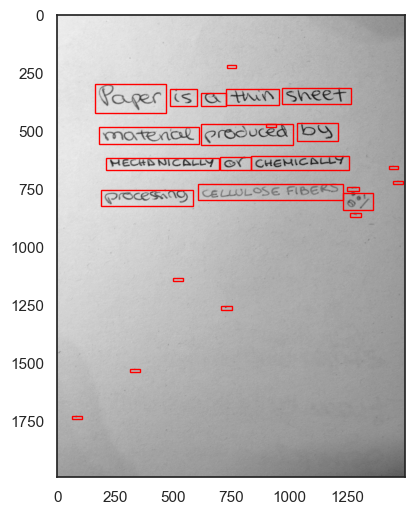

[{'boundingBox': (61, 1730, 43, 13), 'text': 'the'}, {'boundingBox': (314, 1527, 41, 11), 'text': 'the'}, {'boundingBox': (705, 1256, 47, 17), 'text': 'the'}, {'boundingBox': (499, 1136, 42, 12), 'text': 'the'}, {'boundingBox': (1260, 854, 49, 16), 'text': 'the'}, {'boundingBox': (1233, 768, 127, 75), 'text': 'pass'}, {'boundingBox': (186, 753, 399, 73), 'text': 'summer'}, {'boundingBox': (1250, 743, 52, 15), 'text': 'the'}, {'boundingBox': (606, 731, 624, 66), 'text': 'much'}, {'boundingBox': (1446, 715, 46, 14), 'text': 'the'}, {'boundingBox': (1428, 651, 41, 12), 'text': 'the'}, {'boundingBox': (208, 617, 487, 50), 'text': 'common'}, {'boundingBox': (700, 611, 133, 56), 'text': 'ice'}, {'boundingBox': (835, 608, 421, 61), 'text': 'common'}, {'boundingBox': (178, 485, 433, 71), 'text': 'common'}, {'boundingBox': (617, 470, 398, 93), 'text': 'matter'}, {'boundingBox': (900, 470, 43, 14), 'text': 'the'}, {'boundingBox': (1033, 466, 175, 78), 'text': 'do'}, {'boundingBox': (617, 336, 11

In [23]:
files = os.listdir("data/fotos/")
image_files = ["data/fotos/"+i for i in files]
for im_file  in image_files:
    im = cv2.imread(im_file, cv2.IMREAD_GRAYSCALE)
    im = rescale(im)
    print(ocr_box(im, plot=True))
    plt.show()